# STEP 1: LOADING AND ANALYSING DATA

In [1]:
import pandas as pd

In [2]:
sports_train_df = pd.read_csv("bbcsports_train.csv")

In [3]:
print(sports_train_df)

     claxton  hunt  first  major  medal  british  hurdler  sarah  confid  win  \
0          0     0      0      0      0        0        0      0       0    0   
1          0     0      1      0      0        0        0      0       0    1   
2          0     0      1      0      0        0        0      0       0    2   
3          0     0      0      2      0        0        0      0       0    0   
4          0     0      0      0      0        0        0      0       0    1   
..       ...   ...    ...    ...    ...      ...      ...    ...     ...  ...   
547        0     0      0      0      0        0        0      0       0    0   
548        0     0      0      0      0        0        0      0       0    0   
549        0     0      0      0      0        0        0      0       0    2   
550        0     0      1      0      0        0        0      0       1    3   
551        0     0      1      0      0        0        0      0       0    1   

     ...  massu  mcenro  ma

# TEST DATA: Class distribution graph

<AxesSubplot:>

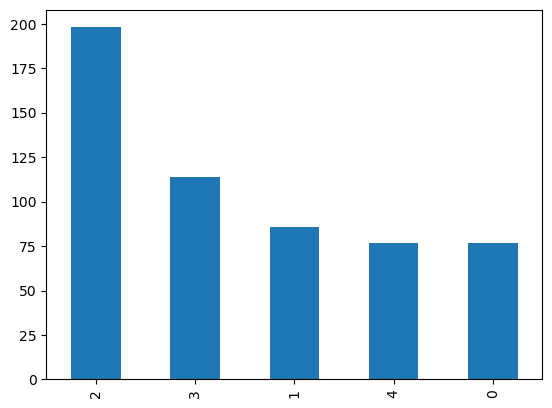

In [4]:
sports_train_df.class_label.value_counts().plot(kind='bar')

In [5]:
sports_train_df.class_label.value_counts()

2    198
3    114
1     86
4     77
0     77
Name: class_label, dtype: int64

# TEST DATA: Class distribution chart

<AxesSubplot:ylabel='class_label'>

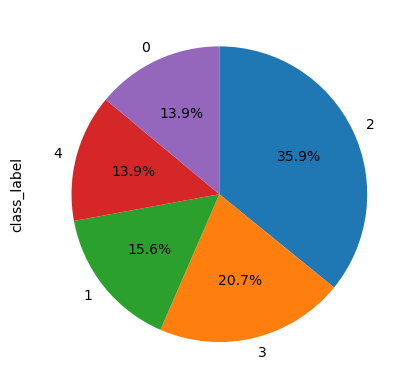

In [6]:
sports_train_df.class_label.value_counts().plot(kind='pie', autopct='%1.1f%%',counterclock=False,startangle=90)

In [7]:
sports_val_df = pd.read_csv("bbcsports_val.csv")

In [8]:
print(sports_val_df)

     claxton  hunt  first  major  medal  british  hurdler  sarah  confid  win  \
0          0     0      0      0      0        0        0      0       0    0   
1          0     0      0      0      0        0        0      0       0    0   
2          0     0      8      1      0        0        0      0       0    0   
3          0     0      0      0      0        0        0      0       0    0   
4          0     0      1      0      0        0        0      0       0    0   
..       ...   ...    ...    ...    ...      ...      ...    ...     ...  ...   
180        0     0      0      0      0        0        0      0       0    3   
181        0     0      5      0      6        1        0      0       0    5   
182        0     0      2      0      0        0        0      0       0    0   
183        0     0      0      0      0        0        0      0       0    1   
184        0     0      0      0      0        0        0      0       0    1   

     ...  massu  mcenro  ma

# VAL DATA: Class distribution graph

<AxesSubplot:>

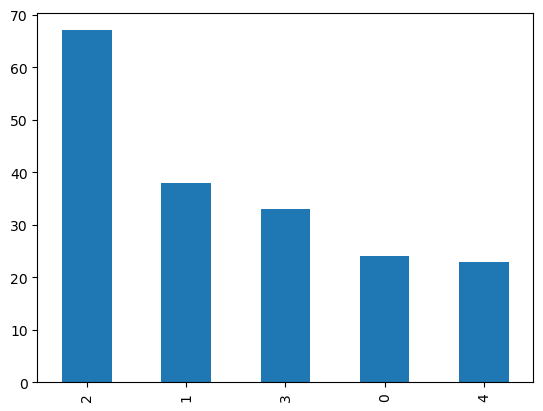

In [9]:
sports_val_df.class_label.value_counts().plot(kind='bar')

In [10]:
sports_val_df.class_label.value_counts()

2    67
1    38
3    33
0    24
4    23
Name: class_label, dtype: int64

# VAL DATA: Class distribution chart

<AxesSubplot:ylabel='class_label'>

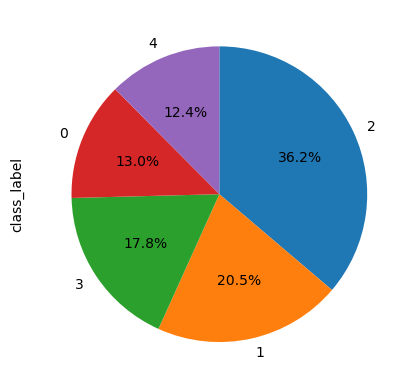

In [11]:
sports_val_df.class_label.value_counts().plot(kind='pie', autopct='%1.1f%%',counterclock=False,startangle=90)

# STEP 2: PREPARING MODEL COMPONENTS

# PI MLE

In [12]:
import numpy as np
pd.options.mode.chained_assignment = None
def piArray(dataset, label):
    # returns est. P(Y = yk)
    arr = np.array(dataset[label].value_counts().sort_index() / len(dataset))
    return arr

In [13]:
piArray(sports_train_df, "class_label" )

array([0.13949275, 0.1557971 , 0.35869565, 0.20652174, 0.13949275])

# THETA MLE

In [14]:
def thetaArray(dataset, label): 
    # returns est. P(Xj |Y = yk) 
    arrO = np.array(dataset.groupby([label]).sum())
    arrO = np.divide(arrO.T, np.sum(arrO,axis=1) ).T 
    return arrO 

In [15]:
dfTry = pd.DataFrame({'word1': [1, 5, 1, 3],
                      'word2': [3, 7, 1, 4], 
                      'class_label': [1, 0, 1, 0]})

In [16]:
print(dfTry)

   word1  word2  class_label
0      1      3            1
1      5      7            0
2      1      1            1
3      3      4            0


In [17]:
marr = thetaArray(dfTry, 'class_label' )
print(marr)

[[0.42105263 0.57894737]
 [0.33333333 0.66666667]]


# CLASSIFICATION AND ACCURACY CALCULATION

In [18]:
def classify(allPredictions):
    argMax = np.array(allPredictions.argmax(axis=1))
    return argMax

def accuracyResults(validLabels, validPredictedLabels): 
    numTrue = 0
    for gtL, predL in zip(validLabels, validPredictedLabels):
        if gtL == predL: 
            numTrue += 1
    numFalse = validLabels.size - numTrue
    print("The number of correct predictions are", numTrue)
    print("The number of incorrect predictions are", numFalse)
    accuracy = (numTrue/len(validLabels))
    print("The accuracy is %", accuracy * 100)

# STEP 3: MULTINOMIAL NB MODEL

In [19]:
class MultinomialNBClassifier:
    
    def __init__(self):
        self.myPi = None
        self.myTheta = None
    
    def fit(self, df_test, label):
        self.myPi = piArray(df_test, label ) #[class0prob, clas1prob....]
        self.myTheta = thetaArray(df_test, label) #[[w1c0 w2c0...][w1c1..]........]
    
    def printer(self):
        print(self.myPi)
        print(self.myTheta)
        
    def predict(self, df_val):
        val_arr = np.array(df_val)
        val_arr_x = val_arr[:,:-1]
        val_arr_y = val_arr[:,-1]
    
        with np.errstate(divide='ignore'):
            dummy = np.log10(self.myTheta)
        dummy[dummy == -np.inf] = -1e308
        dummy = dummy.T
        sumTerm = np.matmul(val_arr_x, dummy)
        allPredictions =  np.add(np.log10(self.myPi), sumTerm)
        predictedLabels = classify(allPredictions)
        return predictedLabels
    
    def confusionMatrix(self, df, label):
        labelVar = df[label]
        predictions = self.predict(df)
        labelVarNum = labelVar.nunique() # number of class variations 
        # class x class matrix
        confusionMatrix = np.zeros(shape=(labelVarNum, labelVarNum))
        for pred, exp in zip(predictions, labelVar):
            confusionMatrix[pred][exp] += 1   
        return confusionMatrix

# MULTINOMIAL NB TEST RESULTS

In [20]:
classifier = MultinomialNBClassifier()
classifier.fit(sports_train_df, 'class_label')
classifier.printer()
pred = classifier.predict(sports_val_df)
print(pred)
accuracyResults(np.array(sports_val_df['class_label']), pred)
classifier.confusionMatrix(sports_val_df,'class_label' )

[0.13949275 0.1557971  0.35869565 0.20652174 0.13949275]
[[8.64154857e-04 8.64154857e-05 3.19737297e-03 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.32842424e-04 8.20769544e-03 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 6.34256176e-05 3.86896267e-03 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 5.97446398e-03 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 9.42785840e-03 ... 2.77289953e-04
  2.77289953e-04 2.77289953e-04]]
[0 0 0 0 4 0 0 0 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 3 0 0
 0 2 1 2 0 0 4 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 4 0 0 2 0 0 0 0 0 2 0 0 0 0 0
 0 0 0 0 4 0 0 0 0 2 0 0 0 0 0 0 0 0 2 0 0 2 1 0 0 0 0 0 0 0 0 0 0 1 1 0 2
 0 0 0 0 0 0 0 2 0 0 3 0 0 0 0 2 0 0 0 0 2 0 3 0 0 1 0 0 0 0 0 0 2 0 0 0 2
 0 0 0 0 0 2 0 0 0 2 2 0 0 0 2 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
The number of correct predictions are 58
The number of incorrect predic

C:\Users\user\AppData\Local\Temp\ipykernel_13560\2411125761.py:24: RuntimeWarning: overflow encountered in matmul
  sumTerm = np.matmul(val_arr_x, dummy)


array([[24., 33., 45., 30., 19.],
       [ 0.,  5.,  0.,  0.,  0.],
       [ 0.,  0., 22.,  0.,  0.],
       [ 0.,  0.,  0.,  3.,  0.],
       [ 0.,  0.,  0.,  0.,  4.]])

# STEP 4: EXTENDING MULTINOMIAL NB MODEL

In [21]:
def thetaArrayExtended(dataset, label, alpha): 
    # returns est. P(Xj |Y = yk) 
    arrO = np.array(dataset.groupby([label]).sum())
    arrO = arrO + alpha
    arrO = np.divide(arrO.T, np.sum(arrO,axis=1) ).T 
    return arrO 

class MultinomialNBClassifierExtended:
    
    def __init__(self):
        self.myPi = None
        self.myTheta = None
    
    def fit(self, df_test, label, alpha):
        self.myPi = piArray(df_test, label) #[class0prob, clas1prob....]
        self.myTheta = thetaArrayExtended(df_test, label, alpha) #[[w1c0 w2c0...][w1c1..]........]
    
    def printer(self):
        print(self.myPi)
        print(self.myTheta)
        
    def predict(self, df_val):
        val_arr = np.array(df_val)
        val_arr_x = val_arr[:,:-1]
        val_arr_y = val_arr[:,-1]

        #with np.errstate(divide='ignore'):
        dummy = np.log10(self.myTheta)
        #dummy[dummy == -np.inf] = -10000000000
        dummy = dummy.T
        sumTerm = np.matmul(val_arr_x, dummy)
        allPredictions =  np.add(np.log10(self.myPi), sumTerm)
        predictedLabels = classify(allPredictions)
        return predictedLabels
    
    def confusionMatrix(self, df, label):
        labelVar = df[label]
        predictions = self.predict(df)
        labelVarNum = labelVar.nunique() # number of class variations 
        # class x class matrix
        confusionMatrix = np.zeros(shape=(labelVarNum, labelVarNum))
        for pred, exp in zip(predictions, labelVar):
            confusionMatrix[pred][exp] += 1   
        return confusionMatrix

# EXTENDED MULTINOMIAL NB TEST RESULTS

In [22]:
classifierExtended = MultinomialNBClassifierExtended()
classifierExtended.fit(sports_train_df, 'class_label', alpha = 1 )
predExtended = classifierExtended.predict(sports_val_df)
print(predExtended)
accuracyResults(np.array(sports_val_df['class_label']), predExtended)
classifierExtended.confusionMatrix(sports_val_df,'class_label' )

[4 2 1 2 4 0 0 1 2 2 1 3 3 1 0 3 1 2 3 3 3 1 2 1 3 2 3 4 3 2 3 2 1 1 3 2 2
 1 2 1 2 0 1 4 3 4 4 4 2 2 2 4 2 4 0 1 0 1 2 4 0 0 2 0 3 2 1 0 2 3 0 4 0 0
 3 1 2 2 4 2 2 2 2 2 3 4 2 2 4 0 2 0 2 4 3 2 1 1 0 1 2 2 2 1 2 1 1 1 1 3 2
 1 4 0 3 2 2 3 2 2 1 3 0 1 2 3 2 3 1 1 4 2 1 3 4 3 1 2 2 3 2 3 2 2 4 3 0 2
 3 4 3 3 3 2 1 2 0 2 2 2 0 3 2 2 3 2 2 1 2 0 3 1 1 2 0 0 4 2 2 3 2 0 4 2 2]
The number of correct predictions are 180
The number of incorrect predictions are 5
The accuracy is % 97.2972972972973


array([[24.,  0.,  0.,  0.,  1.],
       [ 0., 35.,  0.,  0.,  0.],
       [ 0.,  1., 66.,  0.,  0.],
       [ 0.,  2.,  1., 33.,  0.],
       [ 0.,  0.,  0.,  0., 22.]])

# WORD OCCURRENCE DIFFERENCES

In [23]:
a = np.array(sports_train_df.groupby(['class_label']).sum())
print(a)

# find max frequent word num in each class
maxVals = a.max(axis=1)
print(maxVals)
# find min frequent word num in each class
minVals = a.min(axis=1)
print(minVals)

[[ 10   1  37 ...   0   0   0]
 [  0   4 141 ...   0   0   0]
 [  0   2 122 ...   0   0   0]
 [  0   0 124 ...   0   0   0]
 [  0   0 102 ...   3   3   3]]
[143 198 278 296 136]
[0 0 0 0 0]


In [24]:
b = np.array(sports_val_df.groupby(['class_label']).sum())
print(b)

# find max frequent word num in each class
maxVals = b.max(axis=1)
print(maxVals)
# find min frequent word num in each class
minVals = b.min(axis=1)
print(minVals)

[[ 4  0 12 ...  0  0  0]
 [ 0  0 55 ...  0  0  0]
 [ 0  1 41 ...  0  0  0]
 [ 0  0 40 ...  0  0  0]
 [ 0  0 35 ...  2  4  1]]
[ 59  95 148  99  58]
[0 0 0 0 0]


In [25]:
c = np.array(sports_train_df)
c = c.sum(axis = 0)
print(c)

# find max frequent word num in each class
maxVals = c.max()
print(maxVals)
# find min frequent word num in each class
minVals = c.min()
print(minVals)

[  10    7  526 ...    3    3 1132]
1132
0
